In [1]:
import random
import numpy as np

In [2]:
def get_size_a():
    size_a = [14,100,40,4]
    return size_a
    
def get_size_b():
    size_b = [14]
    for i in range(6):
        size_b.append(28)
    size_b.append(4)
    return size_b

def get_size_c():
    size_c = [14]
    for i in range(28):
        size_c.append(14)
    size_c.append(4)
    return size_c

In [3]:
# eg. a_list[-1] = convert_to_hot_vector(np.argmax(a_list[-1]), 4)
def convert_to_hot_vector(y, num_class):
    v = np.zeros(num_class)
    v[y] = 1
    v.shape = (num_class,1)
    return v

# eg. convert_to_hot_vectors(np.array([1, 0, 3]), 4)
def convert_to_hot_vectors(y_s, num_class):
    m = np.zeros((y_s.size, num_class))
    m[np.arange(y_s.size), y_s] = 1
    return m

In [4]:
def relu(x):
    r = x * (x > 0)
    r.shape = x.shape
    return r

def relu_derivative(x):
    d = np.array([1 if i>0 else 0 for i in x])
    d.shape = x.shape
    return d 

def softmax(x):
    """Compute softmax values for each value in x. Minus max to avoid large values in intermidiate steps"""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def cross_entropy(o,y):
    return -np.sum(np.multiply(y, np.log(o)))

In [5]:
class Network(object):
    def __init__(self, sizes, initial_b=None, initial_w=None):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = initial_b if initial_b else [np.random.random((y,1)) - 0.5 for y in sizes[1:]]
        self.weights = initial_w if initial_w else [np.random.random((y,x)) - 0.5 for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward(self, a):
        for b, w in zip(self.biases[0:-1], self.weights[0:-1]):
            a = relu(np.dot(w,a) + b)
        z = np.dot(self.weights[-1], a) + self.biases[-1]
        a = softmax(z)
        return a
    
    def stochastic_gradient_descent(self, training_data, iterations, mini_batch_size, learning_rate, test_data=None):
        """training_data is a list of tupes (x,y). ''test_data'' is used for cost & accuracy evaluation"""
        n = len(training_data)
        training_cost = np.zeros(iterations)
        test_cost = np.zeros(iterations)
        training_accuracy = np.zeros(iterations)
        test_accuracy = np.zeros(iterations)
        for i in range(iterations):
            # evaluate cost & accuracy for training data and test data
            training_cost[i], training_accuracy[i] = self.evaluate(training_data)
            print("Iter", i,": TrC: ", training_cost[i], "; TrA: ",training_accuracy[i])
            if test_data:
                test_cost[i], test_accuracy[i] = self.evaluate(test_data)
                print("Iter ", i,": TeC: ", test_cost[i], "; TeA: ", test_accuracy[i])
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_weights_biases(mini_batch, learning_rate)
        return (training_cost, training_accuracy, test_cost, test_accuracy)
    
    def update_weights_biases(self, mini_batch, learning_rate):
        """The ``mini_batch`` is a list of tuples ``(x, y)``."""
        sum_gradients_b = [np.zeros(b.shape) for b in self.biases]
        sum_gradients_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            gradients_b, gradients_w = self.backpropagate(x, y)
            sum_gradients_b = [sum_gb + gb for sum_gb, gb in zip(sum_gradients_b, gradients_b)]
            sum_gradients_w = [sum_gw + gw for sum_gw, gw in zip(sum_gradients_w, gradients_w)]
        self.biases = [b - learning_rate/len(mini_batch)*gb for b, gb in zip(self.biases, sum_gradients_b)]
        self.weights = [w - learning_rate/len(mini_batch)*gw for w, gw in zip(self.weights, sum_gradients_w)]
    
    def backpropagate(self, x, y):
        gradients_b = [np.zeros(b.shape) for b in self.biases]
        gradients_w = [np.zeros(w.shape) for w in self.weights]
        #feedforward
        a = x
        a_list = [x]
        z_list = []
        for b, w in zip(self.biases[0:-1], self.weights[0:-1]):
            z = np.dot(w, a) + b
            a = relu(z)
            a_list.append(a)
            z_list.append(z)
        z = np.dot(self.weights[-1], a_list[-1]) + self.biases[-1]
        a = softmax(z)
        a_list.append(a)
        z_list.append(z)
        # backward
        # for softmax-cross-entropy layer: delta in last layer = result - ground truth
        delta = a_list[-1] - y
        # update b and w for the last layer L
        gradients_b[-1] = delta
        gradients_w[-1] = np.dot(delta, a_list[-2].transpose())
        # update b and w for the rest of layers L-1, L-2, ... 
        for l in range(2, self.num_layers):
            z = z_list[-l]  # lth last layer of z
            r_derivative = relu_derivative(z)
            # update delta based on delta(l) = transpose of w(l+1) * delta(l+1)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * r_derivative
            gradients_b[-l] = delta
            gradients_w[-l] = np.dot(delta, a_list[-l-1].transpose())
        return (gradients_b, gradients_w)
    
    def evaluate(self, data):
        output = [self.feedforward(x) for x, y in data]
        cost = [cross_entropy(o, d[1]) for o, d in zip(output, data)]
        results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        accuracy = sum(int(x == y) for (x, y) in results)/len(results)
        avg_cost = sum(cost)/len(cost)
        return (avg_cost, accuracy)

    

In [6]:
from numpy import genfromtxt
import os

# prepare data
userhome = os.path.expanduser('~')
shared_path = userhome + r'/Downloads/assignment1/Question2_123'
path_training_x = 'x_train.csv'
path_training_y = 'y_train.csv'
path_test_x = 'x_test.csv'
path_test_y = 'y_test.csv'
training_X =  genfromtxt(os.path.join(shared_path, path_training_x),delimiter=",")
training_Y =  genfromtxt(os.path.join(shared_path, path_training_y),delimiter=",")
training_data = [(x.reshape(14,1), convert_to_hot_vector(int(y),4)) for x, y in zip(training_X,training_Y)]
test_X =  genfromtxt(os.path.join(shared_path, path_test_x),delimiter=",")
test_Y =  genfromtxt(os.path.join(shared_path, path_test_y),delimiter=",")
test_data = [(x.reshape(14,1), convert_to_hot_vector(int(y),4)) for x, y in zip(test_X, test_Y)]
# print(training_data[0][1].shape)

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt

def save_to_file(title, training_cost, training_accuracy, test_cost, test_accuracy):
    userhome = os.path.expanduser('~')
    path = userhome + r'/Downloads/e0047338/toDelete'
    filename = os.path.join(path, title + '.txt')
    np.savetxt(filename, (training_cost, training_accuracy,test_cost,test_accuracy), delimiter=',', fmt='%1.4f')
    
def plot_graph(title, y_1, y_2, size, label_1, label_2, x_label, y_label):
    plt.figure(figsize=(15,7))
    plt.title(title)
    plt.plot(np.arange(0, size, 1), y_1, 'o-', label = label_1)
    plt.plot(np.arange(0, size, 1), y_2, 'o-', label = label_2)
    plt.grid() 
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.legend(loc='best', fontsize=16)

network_b = Network(get_size_b())
training_cost, training_accuracy, test_cost, test_accuracy = network_b.stochastic_gradient_descent(training_data, 1000, 100, 0.1, test_data)

Iter 0 : TrC:  1.60964218419 ; TrA:  0.268329900053
Iter  0 : TeC:  1.58908976391 ; TeA:  0.263960939884
Iter 1 : TrC:  1.64931064016 ; TrA:  0.319829098955
Iter  1 : TeC:  1.66493719171 ; TeA:  0.317973756485
Iter 2 : TrC:  2.34025975259 ; TrA:  0.294804303044
Iter  2 : TeC:  2.34206434275 ; TeA:  0.299664327128
Iter 3 : TrC:  1.85070562665 ; TrA:  0.418554970626
Iter  3 : TeC:  1.86159977888 ; TeA:  0.41287763198
Iter 4 : TrC:  1.43426464007 ; TrA:  0.516136415656
Iter  4 : TeC:  1.46351637748 ; TeA:  0.5090021361
Iter 5 : TrC:  0.599925659662 ; TrA:  0.739833676661
Iter  5 : TeC:  0.646262828329 ; TeA:  0.716814159292
Iter 6 : TrC:  0.804403539322 ; TrA:  0.703898680095
Iter  6 : TeC:  0.84851167902 ; TeA:  0.682941714983
Iter 7 : TrC:  1.14567411061 ; TrA:  0.62180514229
Iter  7 : TeC:  1.18860856415 ; TeA:  0.618248397925
Iter 8 : TrC:  0.677943086822 ; TrA:  0.721904325933
Iter  8 : TeC:  0.713856763651 ; TeA:  0.702471772963
Iter 9 : TrC:  0.935126439435 ; TrA:  0.668726634623
I

Iter 76 : TrC:  1.76142500454 ; TrA:  0.703440909438
Iter  76 : TeC:  1.78312529235 ; TeA:  0.701556301495
Iter 77 : TrC:  0.0332659491458 ; TrA:  0.990310521096
Iter  77 : TeC:  0.103726789425 ; TeA:  0.961245041196
Iter 78 : TrC:  0.183891729066 ; TrA:  0.945830472267
Iter  78 : TeC:  0.276907560239 ; TeA:  0.924015868172
Iter 79 : TrC:  1.87947519803 ; TrA:  0.794155794614
Iter  79 : TeC:  1.9867473628 ; TeA:  0.782728104974
Iter 80 : TrC:  0.0645684484725 ; TrA:  0.973678187228
Iter  80 : TeC:  0.143941297074 ; TeA:  0.945682026244
Iter 81 : TrC:  0.0353161040355 ; TrA:  0.986800946059
Iter  81 : TeC:  0.111237639849 ; TeA:  0.956972841013
Iter 82 : TrC:  0.0370449023608 ; TrA:  0.987716487373
Iter  82 : TeC:  0.101331865194 ; TeA:  0.963686298444
Iter 83 : TrC:  0.890104055327 ; TrA:  0.835507743954
Iter  83 : TeC:  1.05221482698 ; TeA:  0.811107720476
Iter 84 : TrC:  2.40207411493 ; TrA:  0.712596322576
Iter  84 : TeC:  2.62439485201 ; TeA:  0.685993286543
Iter 85 : TrC:  1.20289

Iter 150 : TrC:  0.0054979798901 ; TrA:  0.999008163577
Iter  150 : TeC:  0.0710464668079 ; TeA:  0.977418370461
Iter 151 : TrC:  0.0213084478459 ; TrA:  0.993209735256
Iter  151 : TeC:  0.0955747079559 ; TeA:  0.969484284406
Iter 152 : TrC:  0.149230902347 ; TrA:  0.964370183871
Iter  152 : TeC:  0.277058238611 ; TeA:  0.94140982606
Iter 153 : TrC:  1.55015695213 ; TrA:  0.794384679942
Iter  153 : TeC:  1.60905073553 ; TeA:  0.779981690571
Iter 154 : TrC:  0.0184618060209 ; TrA:  0.994277866789
Iter  154 : TeC:  0.0882789736622 ; TeA:  0.971620384498
Iter 155 : TrC:  0.0207168990391 ; TrA:  0.99267566949
Iter  155 : TeC:  0.100372645457 ; TeA:  0.968873970095
Iter 156 : TrC:  0.00998840165607 ; TrA:  0.997253376059
Iter  156 : TeC:  0.0879836246695 ; TeA:  0.970094598718
Iter 157 : TrC:  0.0040985852648 ; TrA:  0.998855573358
Iter  157 : TeC:  0.0718183010507 ; TeA:  0.976808056149
Iter 158 : TrC:  0.0090367147862 ; TrA:  0.997177080949
Iter  158 : TeC:  0.0997741115514 ; TeA:  0.9697

Iter 228 : TrC:  5.54618803426e-05 ; TrA:  1.0
Iter  228 : TeC:  0.0842601677668 ; TeA:  0.979249313396
Iter 229 : TrC:  5.42103554881e-05 ; TrA:  1.0
Iter  229 : TeC:  0.0836119263235 ; TeA:  0.979859627708
Iter 230 : TrC:  5.33845339817e-05 ; TrA:  1.0
Iter  230 : TeC:  0.0842458168506 ; TeA:  0.979554470552
Iter 231 : TrC:  5.24553669278e-05 ; TrA:  1.0
Iter  231 : TeC:  0.0839278606276 ; TeA:  0.979554470552
Iter 232 : TrC:  5.16351877374e-05 ; TrA:  1.0
Iter  232 : TeC:  0.0842025549965 ; TeA:  0.979554470552
Iter 233 : TrC:  5.08556899118e-05 ; TrA:  1.0
Iter  233 : TeC:  0.0840128100116 ; TeA:  0.979554470552
Iter 234 : TrC:  5.00469905376e-05 ; TrA:  1.0
Iter  234 : TeC:  0.0846331076706 ; TeA:  0.979554470552
Iter 235 : TrC:  4.92926136341e-05 ; TrA:  1.0
Iter  235 : TeC:  0.084684132464 ; TeA:  0.979554470552
Iter 236 : TrC:  4.86006928229e-05 ; TrA:  1.0
Iter  236 : TeC:  0.0846227572648 ; TeA:  0.979554470552
Iter 237 : TrC:  4.78603878288e-05 ; TrA:  1.0
Iter  237 : TeC:  

Iter  307 : TeC:  0.09352699858 ; TeA:  0.97894415624
Iter 308 : TrC:  2.2675490999e-05 ; TrA:  1.0
Iter  308 : TeC:  0.0937332520395 ; TeA:  0.978638999085
Iter 309 : TrC:  2.24935869739e-05 ; TrA:  1.0
Iter  309 : TeC:  0.0937525683673 ; TeA:  0.978638999085
Iter 310 : TrC:  2.23248368379e-05 ; TrA:  1.0
Iter  310 : TeC:  0.0937477219363 ; TeA:  0.97894415624
Iter 311 : TrC:  2.21514301364e-05 ; TrA:  1.0
Iter  311 : TeC:  0.0939931085674 ; TeA:  0.978638999085
Iter 312 : TrC:  2.19855154288e-05 ; TrA:  1.0
Iter  312 : TeC:  0.0940428883149 ; TeA:  0.978638999085
Iter 313 : TrC:  2.18325688375e-05 ; TrA:  1.0
Iter  313 : TeC:  0.0940189679608 ; TeA:  0.978638999085
Iter 314 : TrC:  2.16585965049e-05 ; TrA:  1.0
Iter  314 : TeC:  0.0941257284666 ; TeA:  0.978638999085
Iter 315 : TrC:  2.15053011232e-05 ; TrA:  1.0
Iter  315 : TeC:  0.0942198665299 ; TeA:  0.97894415624
Iter 316 : TrC:  2.13388671294e-05 ; TrA:  1.0
Iter  316 : TeC:  0.0943184713579 ; TeA:  0.97894415624
Iter 317 : TrC

Iter 387 : TrC:  1.3835363163e-05 ; TrA:  1.0
Iter  387 : TeC:  0.100095237965 ; TeA:  0.978333841929
Iter 388 : TrC:  1.37583145731e-05 ; TrA:  1.0
Iter  388 : TeC:  0.100029258502 ; TeA:  0.978333841929
Iter 389 : TrC:  1.36874640814e-05 ; TrA:  1.0
Iter  389 : TeC:  0.100061964919 ; TeA:  0.978333841929
Iter 390 : TrC:  1.36193242155e-05 ; TrA:  1.0
Iter  390 : TeC:  0.0999896711029 ; TeA:  0.978333841929
Iter 391 : TrC:  1.35487581888e-05 ; TrA:  1.0
Iter  391 : TeC:  0.100089592187 ; TeA:  0.978333841929
Iter 392 : TrC:  1.34882383385e-05 ; TrA:  1.0
Iter  392 : TeC:  0.100109419147 ; TeA:  0.978333841929
Iter 393 : TrC:  1.34123888456e-05 ; TrA:  1.0
Iter  393 : TeC:  0.100236978267 ; TeA:  0.978333841929
Iter 394 : TrC:  1.33449702233e-05 ; TrA:  1.0
Iter  394 : TeC:  0.100278681186 ; TeA:  0.978333841929
Iter 395 : TrC:  1.32803785263e-05 ; TrA:  1.0
Iter  395 : TeC:  0.100365418927 ; TeA:  0.978333841929
Iter 396 : TrC:  1.32153605095e-05 ; TrA:  1.0
Iter  396 : TeC:  0.100496

Iter 467 : TrC:  9.6991231085e-06 ; TrA:  1.0
Iter  467 : TeC:  0.104323579496 ; TeA:  0.978333841929
Iter 468 : TrC:  9.66133886429e-06 ; TrA:  1.0
Iter  468 : TeC:  0.104335038635 ; TeA:  0.978333841929
Iter 469 : TrC:  9.62448877565e-06 ; TrA:  1.0
Iter  469 : TeC:  0.104413682191 ; TeA:  0.978333841929
Iter 470 : TrC:  9.58802350369e-06 ; TrA:  1.0
Iter  470 : TeC:  0.104478392057 ; TeA:  0.978333841929
Iter 471 : TrC:  9.55175899859e-06 ; TrA:  1.0
Iter  471 : TeC:  0.104470889322 ; TeA:  0.978333841929
Iter 472 : TrC:  9.51561247299e-06 ; TrA:  1.0
Iter  472 : TeC:  0.104519478548 ; TeA:  0.978333841929
Iter 473 : TrC:  9.48018508911e-06 ; TrA:  1.0
Iter  473 : TeC:  0.104550316597 ; TeA:  0.978333841929
Iter 474 : TrC:  9.44449143211e-06 ; TrA:  1.0
Iter  474 : TeC:  0.104611304056 ; TeA:  0.978333841929
Iter 475 : TrC:  9.40884569471e-06 ; TrA:  1.0
Iter  475 : TeC:  0.104683867936 ; TeA:  0.978333841929
Iter 476 : TrC:  9.37399853192e-06 ; TrA:  1.0
Iter  476 : TeC:  0.1046695

Iter 547 : TrC:  7.36926429031e-06 ; TrA:  1.0
Iter  547 : TeC:  0.107904907225 ; TeA:  0.978333841929
Iter 548 : TrC:  7.34706616541e-06 ; TrA:  1.0
Iter  548 : TeC:  0.107986253867 ; TeA:  0.978638999085
Iter 549 : TrC:  7.32472490059e-06 ; TrA:  1.0
Iter  549 : TeC:  0.108028381888 ; TeA:  0.978333841929
Iter 550 : TrC:  7.3025741698e-06 ; TrA:  1.0
Iter  550 : TeC:  0.108062766078 ; TeA:  0.978333841929
Iter 551 : TrC:  7.28063852335e-06 ; TrA:  1.0
Iter  551 : TeC:  0.108123036925 ; TeA:  0.978333841929
Iter 552 : TrC:  7.25879419273e-06 ; TrA:  1.0
Iter  552 : TeC:  0.108141174104 ; TeA:  0.978333841929
Iter 553 : TrC:  7.23993037491e-06 ; TrA:  1.0
Iter  553 : TeC:  0.108308351357 ; TeA:  0.978333841929
Iter 554 : TrC:  7.21581579862e-06 ; TrA:  1.0
Iter  554 : TeC:  0.108263129124 ; TeA:  0.978333841929
Iter 555 : TrC:  7.19356478167e-06 ; TrA:  1.0
Iter  555 : TeC:  0.108246370302 ; TeA:  0.978333841929
Iter 556 : TrC:  7.17207093483e-06 ; TrA:  1.0
Iter  556 : TeC:  0.1082756

Iter 627 : TrC:  5.90005915982e-06 ; TrA:  1.0
Iter  627 : TeC:  0.11092518279 ; TeA:  0.978333841929
Iter 628 : TrC:  5.88528083775e-06 ; TrA:  1.0
Iter  628 : TeC:  0.110966584021 ; TeA:  0.978333841929
Iter 629 : TrC:  5.87058555017e-06 ; TrA:  1.0
Iter  629 : TeC:  0.110997535783 ; TeA:  0.978333841929
Iter 630 : TrC:  5.85588855871e-06 ; TrA:  1.0
Iter  630 : TeC:  0.111028387144 ; TeA:  0.978333841929
Iter 631 : TrC:  5.84128658107e-06 ; TrA:  1.0
Iter  631 : TeC:  0.111059365219 ; TeA:  0.978333841929
Iter 632 : TrC:  5.82662583611e-06 ; TrA:  1.0
Iter  632 : TeC:  0.111092223887 ; TeA:  0.978333841929
Iter 633 : TrC:  5.81237108476e-06 ; TrA:  1.0
Iter  633 : TeC:  0.111141514446 ; TeA:  0.978333841929
Iter 634 : TrC:  5.79799234727e-06 ; TrA:  1.0
Iter  634 : TeC:  0.111179664978 ; TeA:  0.978333841929
Iter 635 : TrC:  5.78357207387e-06 ; TrA:  1.0
Iter  635 : TeC:  0.111199488235 ; TeA:  0.978333841929
Iter 636 : TrC:  5.7693526019e-06 ; TrA:  1.0
Iter  636 : TeC:  0.11120488

Iter 707 : TrC:  4.89972578267e-06 ; TrA:  1.0
Iter  707 : TeC:  0.113415611938 ; TeA:  0.978638999085
Iter 708 : TrC:  4.88931074868e-06 ; TrA:  1.0
Iter  708 : TeC:  0.113447743622 ; TeA:  0.978638999085
Iter 709 : TrC:  4.87872257356e-06 ; TrA:  1.0
Iter  709 : TeC:  0.113478216685 ; TeA:  0.978638999085
Iter 710 : TrC:  4.86834115556e-06 ; TrA:  1.0
Iter  710 : TeC:  0.113516967686 ; TeA:  0.978638999085
Iter 711 : TrC:  4.85791195418e-06 ; TrA:  1.0
Iter  711 : TeC:  0.113531201676 ; TeA:  0.978638999085
Iter 712 : TrC:  4.84764580582e-06 ; TrA:  1.0
Iter  712 : TeC:  0.11357565117 ; TeA:  0.978638999085
Iter 713 : TrC:  4.83730230149e-06 ; TrA:  1.0
Iter  713 : TeC:  0.113606316448 ; TeA:  0.978638999085
Iter 714 : TrC:  4.82700085141e-06 ; TrA:  1.0
Iter  714 : TeC:  0.113634446332 ; TeA:  0.978638999085
Iter 715 : TrC:  4.81685186344e-06 ; TrA:  1.0
Iter  715 : TeC:  0.113649467679 ; TeA:  0.978638999085
Iter 716 : TrC:  4.80660619547e-06 ; TrA:  1.0
Iter  716 : TeC:  0.1136951

Iter 787 : TrC:  4.17181972941e-06 ; TrA:  1.0
Iter  787 : TeC:  0.115484832316 ; TeA:  0.97894415624
Iter 788 : TrC:  4.1639846504e-06 ; TrA:  1.0
Iter  788 : TeC:  0.115519066251 ; TeA:  0.97894415624
Iter 789 : TrC:  4.15607237867e-06 ; TrA:  1.0
Iter  789 : TeC:  0.115562250583 ; TeA:  0.97894415624
Iter 790 : TrC:  4.14825027867e-06 ; TrA:  1.0
Iter  790 : TeC:  0.115596060962 ; TeA:  0.97894415624
Iter 791 : TrC:  4.14036789352e-06 ; TrA:  1.0
Iter  791 : TeC:  0.115616174511 ; TeA:  0.97894415624
Iter 792 : TrC:  4.13254594301e-06 ; TrA:  1.0
Iter  792 : TeC:  0.115640159788 ; TeA:  0.97894415624
Iter 793 : TrC:  4.12489457888e-06 ; TrA:  1.0
Iter  793 : TeC:  0.115666740413 ; TeA:  0.97894415624
Iter 794 : TrC:  4.11725685202e-06 ; TrA:  1.0
Iter  794 : TeC:  0.115682474554 ; TeA:  0.97894415624
Iter 795 : TrC:  4.10975688239e-06 ; TrA:  1.0
Iter  795 : TeC:  0.115673897182 ; TeA:  0.979249313396
Iter 796 : TrC:  4.10204556497e-06 ; TrA:  1.0
Iter  796 : TeC:  0.115701009959 ; 

Iter 867 : TrC:  3.61911094888e-06 ; TrA:  1.0
Iter  867 : TeC:  0.11739803863 ; TeA:  0.97894415624
Iter 868 : TrC:  3.61298649302e-06 ; TrA:  1.0
Iter  868 : TeC:  0.117416166642 ; TeA:  0.979249313396
Iter 869 : TrC:  3.60712439464e-06 ; TrA:  1.0
Iter  869 : TeC:  0.117452360842 ; TeA:  0.979249313396
Iter 870 : TrC:  3.60090087578e-06 ; TrA:  1.0
Iter  870 : TeC:  0.117447060657 ; TeA:  0.979249313396
Iter 871 : TrC:  3.59495795552e-06 ; TrA:  1.0
Iter  871 : TeC:  0.117469809766 ; TeA:  0.979249313396
Iter 872 : TrC:  3.58934454336e-06 ; TrA:  1.0
Iter  872 : TeC:  0.11752380088 ; TeA:  0.97894415624
Iter 873 : TrC:  3.58323453025e-06 ; TrA:  1.0
Iter  873 : TeC:  0.117532101757 ; TeA:  0.97894415624
Iter 874 : TrC:  3.57712400795e-06 ; TrA:  1.0
Iter  874 : TeC:  0.117544237801 ; TeA:  0.979249313396
Iter 875 : TrC:  3.57104512051e-06 ; TrA:  1.0
Iter  875 : TeC:  0.117550119096 ; TeA:  0.979249313396
Iter 876 : TrC:  3.56516611261e-06 ; TrA:  1.0
Iter  876 : TeC:  0.11750157667

Iter 947 : TrC:  3.18507662249e-06 ; TrA:  1.0
Iter  947 : TeC:  0.11902706915 ; TeA:  0.979554470552
Iter 948 : TrC:  3.18019801499e-06 ; TrA:  1.0
Iter  948 : TeC:  0.119046559217 ; TeA:  0.979554470552
Iter 949 : TrC:  3.17542873048e-06 ; TrA:  1.0
Iter  949 : TeC:  0.119100845537 ; TeA:  0.979554470552
Iter 950 : TrC:  3.17055780449e-06 ; TrA:  1.0
Iter  950 : TeC:  0.119101803955 ; TeA:  0.979554470552
Iter 951 : TrC:  3.16575946835e-06 ; TrA:  1.0
Iter  951 : TeC:  0.119128138574 ; TeA:  0.979554470552
Iter 952 : TrC:  3.16096556811e-06 ; TrA:  1.0
Iter  952 : TeC:  0.119150403123 ; TeA:  0.979554470552
Iter 953 : TrC:  3.15622767022e-06 ; TrA:  1.0
Iter  953 : TeC:  0.119169232498 ; TeA:  0.979554470552
Iter 954 : TrC:  3.15152010376e-06 ; TrA:  1.0
Iter  954 : TeC:  0.119184344727 ; TeA:  0.979554470552
Iter 955 : TrC:  3.14676497128e-06 ; TrA:  1.0
Iter  955 : TeC:  0.119196260079 ; TeA:  0.979554470552
Iter 956 : TrC:  3.14213118123e-06 ; TrA:  1.0
Iter  956 : TeC:  0.1192082

In [8]:
save_to_file('14-28-6-4', training_cost, training_accuracy, test_cost, test_accuracy)

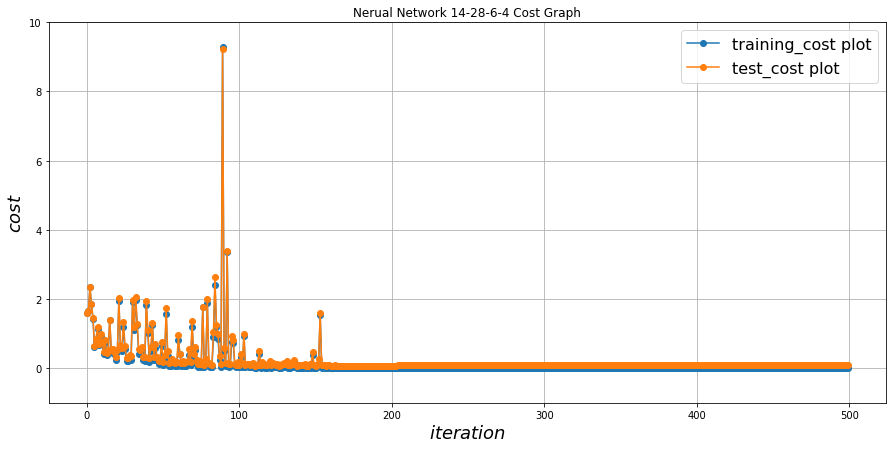

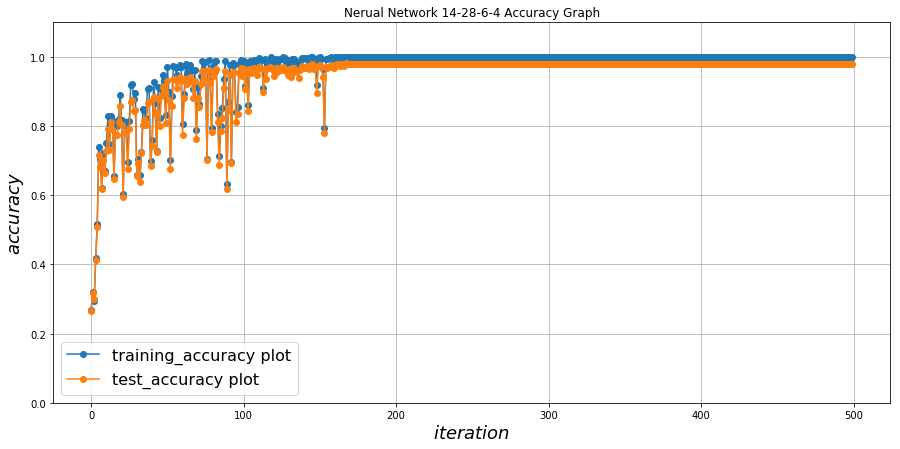

In [19]:
def plot_graph(title, y_1, y_2, size, label_1, label_2, x_label, y_label, y_lim):
    plt.figure(figsize=(15,7))
    plt.title(title)
    plt.plot(np.arange(0, size, 1), y_1, 'o-', label = label_1)
    plt.plot(np.arange(0, size, 1), y_2, 'o-', label = label_2)
    plt.grid() 
    plt.ylim(y_lim)
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.legend(loc='best', fontsize=16)

cost_title = 'Nerual Network 14-28-6-4 Cost Graph'
accuracy_title = 'Nerual Network 14-28-6-4 Accuracy Graph'
plot_graph(cost_title, training_cost[:500], test_cost[:500], 500, 'training_cost plot', 'test_cost plot', '$iteration$', '$cost$',(-1,10))
# plot_graph(accuracy_title, training_accuracy, test_accuracy, training_accuracy.size, 'training_accuracy plot', 'test_accuracy plot', '$iteration$', '$accuracy$')
plot_graph(accuracy_title, training_accuracy[:500], test_accuracy[:500], 500, 'training_accuracy plot', 'test_accuracy plot', '$iteration$', '$accuracy$',(0,1.1))

In [10]:
def check_shape(list_of_arrays):
    shapes = [b.shape for b in list_of_arrays]
    print(shapes)

In [11]:
# import csv
# import os

# x = np.array([-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1])
# x.shape = (14,1)
# y = convert_to_hot_vector(3,4)
# y.shape = (4,1)

# userhome = os.path.expanduser('~')
# shared_path = userhome + r'/Downloads/assignment1/Question2_4/b'
# path_b_a = 'b-100-40-4.csv'
# path_w_a = 'w-100-40-4.csv'
# path_b_b = 'b-28-6-4.csv'
# path_w_b = 'w-28-6-4.csv'
# path_b_c = 'b-14-28-4.csv'
# path_w_c = 'w-14-28-4.csv'

# def output_gradient(x, y, sizes, shared_path, path_b, path_w):
#     biases = [np.zeros((y,1)) for y in sizes[1:]]
#     weights = [np.zeros((y,x)) for x, y in zip(sizes[:-1],sizes[1:])]
#     with open(os.path.join(shared_path,path_b), newline='') as file:
#         reader = csv.reader(file)
#         for row, i in zip(reader,range(len(biases))):
#             biases[i] = np.array([np.float32(v) for v in row[1:]])
#             biases[i].shape = (len(row[1:]),1)
#     with open(os.path.join(shared_path,path_w), newline='') as file:
#         reader = csv.reader(file)
#         indexes = [sum(sizes[0:i+1])  for i in range(len(sizes))]
#         index = 0
#         wts = [w.transpose() for w in weights]
#         for row, i in zip(reader,range(sum(sizes[:-1]))):
#             index = index + 1 if i >= indexes[index] else index
#             index_w = i - indexes[index-1] if index > 0 else i
#             wts[index][index_w] = [np.float32(v) for v in row[1:]]
#     weights = [wt.transpose() for wt in wts]      
#     network_a = Network(sizes, biases, weights)
#     gradients_b, gradients_w = network_a.backpropagate(x, y)
#     path_db = os.path.join(shared_path,'d'+path_b)
#     path_dw = os.path.join(shared_path,'d'+path_w)
#     with open(path_db, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile, delimiter=',')
#         for gb in gradients_b:
#             n = [db[0] for db in gb]
#             writer.writerow(n)
#     with open(path_dw, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile, delimiter=',')
#         for gw in gradients_w:
#             dw = gw.transpose()
#             for row in dw:
#                 writer.writerow(row)
            

# output_gradient(x,y,get_size_a(),shared_path,path_b_a, path_w_a)
# print('complete a')
# output_gradient(x,y,get_size_b(),shared_path,path_b_b, path_w_b)
# print('complete b')
# output_gradient(x,y,get_size_c(),shared_path,path_b_c, path_w_c)
# print('complete c')

# shared_path = userhome + r'/Downloads/assignment1/Question2_4/c'
# output_gradient(x,y,get_size_a(),shared_path,path_b_a, path_w_a)
# print('complete test a')
# output_gradient(x,y,get_size_b(),shared_path,path_b_b, path_w_b)
# print('complete test b')
# output_gradient(x,y,get_size_c(),shared_path,path_b_c, path_w_c)
# print('complete test c')